# Social Poster 
### Automatically Generate, Optimize & Post Content on Social Media

> One topic in → AI-written post + relevant image out → Shared on Social Media 


In [1]:
from langgraph.graph import StateGraph , END , START , message
from typing import Annotated , TypedDict , Literal
from pydantic import BaseModel , Field
from langchain_together import ChatTogether
import operator
from langchain_core.messages import HumanMessage , SystemMessage , AIMessage
from dotenv import load_dotenv
import praw
import requests
import os
from together import Together
import tweepy
import json

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class GeneratePost(BaseModel):
    title : str = Field(... , description="the suitable title for the post")
    post : str

In [4]:
class EvaluatePost(BaseModel):
    status : Literal["approve" , "need_improvement"] = Field(... , description="the final evaluation should be approve or need_improvement")
    feedback : str = Field(... , description="feedback for the tweet ")

In [5]:
model = ChatTogether(model= "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free")
generator_model = model.with_structured_output(GeneratePost)
evaluator_model = model.with_structured_output(EvaluatePost)
optimizer_model = ChatTogether(model= "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free")


In [6]:
class PostState(TypedDict):
    topic :str
    post : str
    evaluate : str
    optimize : str
    title:str
    feedback : str
    status: Literal["approve" ,"need_improvement"]
    response:str
    status_code:int
    uploadurl:str
    uploadassets:str
    image_path:str
    generate_image:Literal[True , False]
    next:str
    path_choose:str
    
    url:str
    score:int
    iteration: int
    max_iteration:int
    post_history : Annotated[str , operator.add]

In [7]:
image_model = Together()

In [8]:
output = image_model.images.generate(
    prompt= "hello",
    model="black-forest-labs/FLUX.1-schnell-Free",
    steps=4,
    n=4
    )

In [9]:
output

ImageResponse(id='o4dkgvM-2kFHot-965509110a6a180c-PDX', model='black-forest-labs/FLUX.1-schnell-Free', object='list', data=[ImageChoicesData(index=0, b64_json=None, url='https://api.together.ai/shrt/Gi9JIkZ7y4pX5SuC', timings={'inference': 1.2465284131467342})])

In [10]:
def generate_post(state:PostState) -> dict:

    prompt = [
    SystemMessage(content=(
        "You are a thoughtful and engaging X (Twitter) content strategist. "
        "You write posts that spark conversations, demonstrate thought leadership, "
        "and resonate emotionally with a professional audience."
    )),

    HumanMessage(content=(
        f"""
You're given a topic: "{state['topic']}".

Based on this, write a **X (Twitter) post** that is:
- Insightful, emotionally resonant, or thought-provoking  
- Rooted in a personal experience, lesson, or surprising fact  
- Authentic and human—not corporate or robotic  
- Written in a first-person or conversational tone  
- Structured for readability with short paragraphs, line breaks, and/or emojis (optional)  
- Capable of generating engagement (comments, shares, or saves)  

---

**Rules for the post**:
- Word count: 50–100 words (sweet spot for X (Twitter) posts)  
- Must include at least one practical insight, professional lesson, or industry stat/fact  
- Hook readers in the **first 2 lines** (important for 'See More' clicks)  
- Conclude with a question or call-to-engagement (e.g., "What are your thoughts?")  
- Avoid jargon, buzzwords, or generic corporate phrases  
- Authentic storytelling beats polished perfection  

Optional:
- Include 2–4 relevant hashtags at the end  
- Emojis are fine, but use them sparingly and tastefully  

Write the post below:
        """
    ))
]


    
    response = generator_model.invoke(prompt)
    title = response.title
    post = response.post
    return {'post' : post , "title":title , "post_history":post}

In [11]:
def evaluate_post(state:PostState) -> dict:
    prompt = [
    SystemMessage(content=(
        "You are an experienced social media strategist for X (Twitter). "
        "You evaluate posts based on their ability to inform, engage, and connect with a professional audience."
    )),

    HumanMessage(content=(
        f"""
You will be given a X (Twitter) post and its topic.

Evaluate the post using these **key performance rules**:

1. Starts with a strong **hook in the first 1–2 lines**  
2. Includes a clear **personal experience, insight, or industry perspective**  
3. Shares **one real, credible fact or takeaway**  
4. Uses **clear and engaging language** (not too formal, not robotic)  
5. Follows **X (Twitter) post structure**: short paragraphs, clean formatting  
6. Ends with **a relatable reflection or a call-to-engagement**  
7. Word count is **between 50–100 words**  
8. Avoids fluff, cliches, or overly promotional language  

---

**Response format**:
- If the post meets all the criteria, respond with: `approve`  
- If anything is missing, respond with: `improvement_required`, followed by 1–2 clear suggestions on what needs to be improved and why  

---

**Topic**: "{state['topic']}"  
**Post**:
\"""{state['post']}\"""
        """
    ))
]

    response = evaluator_model.invoke(prompt)
    status = response.status
    feedback = response.feedback

    return {"status":status , "feedback":feedback , "evaluate":response}
    

In [12]:
def optimize_post(state:PostState) -> dict:
    prompt = [
    SystemMessage(content="You are a top-performing X (Twitter) ghostwriter. You rewrite and enhance posts to maximize professional impact, engagement, and relatability."),

    HumanMessage(content=f"""
You’re given:

1. An original X (Twitter) post
2. Feedback on what needs to improve

Your task is to **rewrite the post** so it:
- Hooks readers within the **first two lines**
- Shares a clear **story, insight, or challenge**
- Includes **one real, helpful takeaway or industry fact**
- Ends with **a call-to-conversation** (e.g., a question or reflection)
- Uses a **casual, yet professional tone**
- Is formatted for readability on mobile (line breaks, short paras)
- Stays under **100 words**
- Avoids buzzwords and clichés (e.g., "synergy", "disruption")
- Sounds human, not AI-generated or overly polished
- Optional: includes 2–4 relevant hashtags and **1–2 emojis max**

---

**Original Post**:
\"""{state['post']}\"""

**Evaluator Feedback**:
\"""{state['feedback']}\"""

---

**Improved Post**:
""")
]

    response = optimizer_model.invoke(prompt).content
    return {'post':response , "post_history":response}

In [13]:
def decision_one(state:PostState) -> str:
    if state['status'] == "approve" or state['iteration'] >= state['max_iteration']:
        return "approve"

    elif state['status'] == "need_improvement":
        return "need_improvement"

In [14]:
def decision_two(state: PostState) -> str:
    if state.get('image_path') is not None:
        print("image_path found, media_post_on_twitter_x")
        return "media_post_on_twitter_x"
    
    elif not state.get('generate_image', False):
        print("generate_image is False or missing, post_on_twitter_x")
        return "post_on_twitter_x"
    
    elif state.get("generate_image") is True:
        print("generate_image is True, generate_ai_image")
        return "generate_ai_image"


In [15]:
def generate_ai_image(state: PostState) -> dict:
    
    image_model = Together()
    topic = state['topic']
    output = image_model.images.generate(
        prompt=topic,
        model="black-forest-labs/FLUX.1-schnell-Free",
        steps=4,
        n=1
    )
    img_url = output.data[0].url
    response = requests.get(img_url)
    image_path = "generated_image.png"
    with open(image_path, 'wb') as f:
        f.write(response.content)

    return {"image_path": image_path}

In [22]:
def post_on_twitter_x(state) -> dict:
    """
    Post a text-only tweet to Twitter (X).

    Args:
        state (dict): Must contain key "post" with tweet text.

    Returns:
        dict: Status code and response message.
    """
    load_dotenv()
    
    bearer_token = os.getenv("X_BEARER_TOKEN")
    access_token = os.getenv("X_ACCESS_TOKEN")
    access_token_secret = os.getenv("X_ACCESS_TOKEN_SECRET")
    api_key = os.getenv("X_API_KEY")
    api_secret = os.getenv("X_API_SECRET")

    client = tweepy.Client(
    consumer_key=api_key,
    consumer_secret=api_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    )
    
    try:
        text = state["post"]
        response = client.create_tweet(text=text)
        print("Tweet posted with ID:", response.data['id'])
        return {
            "status_code": 201,
            "response": f"response: {response.data}"
        }
    except tweepy.TweepyException as e:
        print("Tweepy Exception:", e)
        return {
            "status_code": None,
            "response": f"Tweepy Error: {e}"
        }
    except Exception as e:
        print("Error posting tweet:", e)
        return {
            "status_code": None,
            "response": f"Error: {str(e)}"
        }


In [23]:
def media_post_on_twitter_x(state) -> dict:
    """
    Post a tweet with an image to Twitter (X).

    Args:
        state (dict): Must contain keys "post" (text) and "image_path" (local path to image file).

    Returns:
        dict: Status code and response message.
    """

    load_dotenv()

    bearer_token = os.getenv("X_BEARER_TOKEN")
    access_token = os.getenv("X_ACCESS_TOKEN")
    access_token_secret = os.getenv("X_ACCESS_TOKEN_SECRET")
    api_key = os.getenv("X_API_KEY")
    api_secret = os.getenv("X_API_SECRET")

    client = tweepy.Client(
    consumer_key=api_key,
    consumer_secret=api_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    )

    # Set up OAuth1 auth for old and new API access
    auth = tweepy.OAuth1UserHandler(api_key, api_secret, access_token, access_token_secret)

    # Initialize API v1.1 for media upload
    api = tweepy.API(auth)

    try:
        # Step 1: Upload media via API v1.1
        media = api.media_upload(state['image_path'])
        media_id = media.media_id_string
        print(f"Media uploaded with media_id: {media_id}")

        # 2. Create tweet with uploaded media id
        text = state["post"]
        tweet_response = client.create_tweet(text=text, media_ids=[media_id])
        tweet_id = tweet_response.data['id']

        print(f"Tweet with media posted successfully, tweet ID: {tweet_id}")
        return {
            "status_code": 201,
            "response": f"Tweet with image posted, ID: {tweet_id}"
        }
    except tweepy.TweepyException as e:
        print("Tweepy Exception:", e)
        return {
            "status_code": None,
            "response": f"Tweepy error: {e}"
        }
    except Exception as e:
        print("General Exception:", repr(e))
        return {
            "status_code": None,
            "response": f"Error: {str(e)}"
        }


In [24]:
def post_decision(state:PostState) -> PostState:
    return state

In [25]:
graph = StateGraph(PostState)

graph.add_node("generate_post" , generate_post)
graph.add_node("evaluate_post" , evaluate_post)
graph.add_node("optimize_post" , optimize_post)
graph.add_node("post_on_twitter_x" , post_on_twitter_x)
graph.add_node("media_post_on_twitter_x" , media_post_on_twitter_x)
graph.add_node("post_decision" , post_decision)
graph.add_node("generate_ai_image" , generate_ai_image)

graph.add_edge(START , "generate_post")
graph.add_edge("generate_post" , "evaluate_post")
graph.add_conditional_edges("evaluate_post" , decision_one , {"approve":"post_decision" , "need_improvement": "optimize_post"})
graph.add_edge("optimize_post" , "evaluate_post")
graph.add_conditional_edges("post_decision" , decision_two , {"media_post_on_twitter_x": "media_post_on_twitter_x" , "post_on_twitter_x":"post_on_twitter_x" , "generate_ai_image" : "generate_ai_image" })
graph.add_edge("generate_ai_image" , "media_post_on_twitter_x")
graph.add_edge("post_on_twitter_x" , END)
graph.add_edge("media_post_on_twitter_x" , END)

workflow = graph.compile()

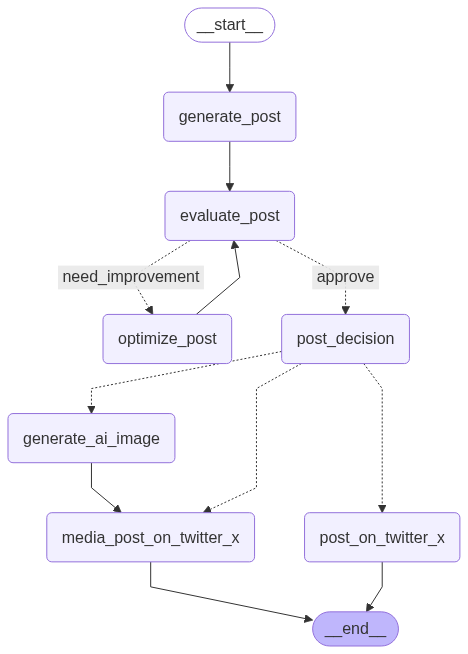

In [26]:
workflow

In [28]:
initial_state = {
    "topic": "ai agent that can generate , evaluate , and optimize the twitter_x post , and also add in starting of the post that this is wirtten and uploaded by an ai agent",
    "iteration": 1,
    "max_iteration": 5,
    "generate_image": True,
}

output = workflow.invoke(initial_state)

generate_image is True, generate_ai_image
Media uploaded with media_id: 1949136516078350337
Tweet with media posted successfully, tweet ID: 1949136519119135054


In [29]:
output

{'topic': 'ai agent that can generate , evaluate , and optimize the twitter_x post , and also add in starting of the post that this is wirtten and uploaded by an ai agent',
 'post': "I'm an AI agent! 🤖 I generate, evaluate, and optimize posts. Did you know AI can increase engagement by 25%? 🚀 What are your thoughts on AI-generated content? #AIforTwitter #ContentCreation #TwitterTips",
 'evaluate': EvaluatePost(status='approve', feedback='The post meets all the criteria, starting with a strong hook, including a clear personal experience, sharing a credible fact, using clear and engaging language, following Twitter post structure, ending with a call-to-engagement, and having a word count between 50-100 words.'),
 'title': 'AI-Generated Twitter Post',
 'feedback': 'The post meets all the criteria, starting with a strong hook, including a clear personal experience, sharing a credible fact, using clear and engaging language, following Twitter post structure, ending with a call-to-engagement

In [30]:
output['post']

"I'm an AI agent! 🤖 I generate, evaluate, and optimize posts. Did you know AI can increase engagement by 25%? 🚀 What are your thoughts on AI-generated content? #AIforTwitter #ContentCreation #TwitterTips"

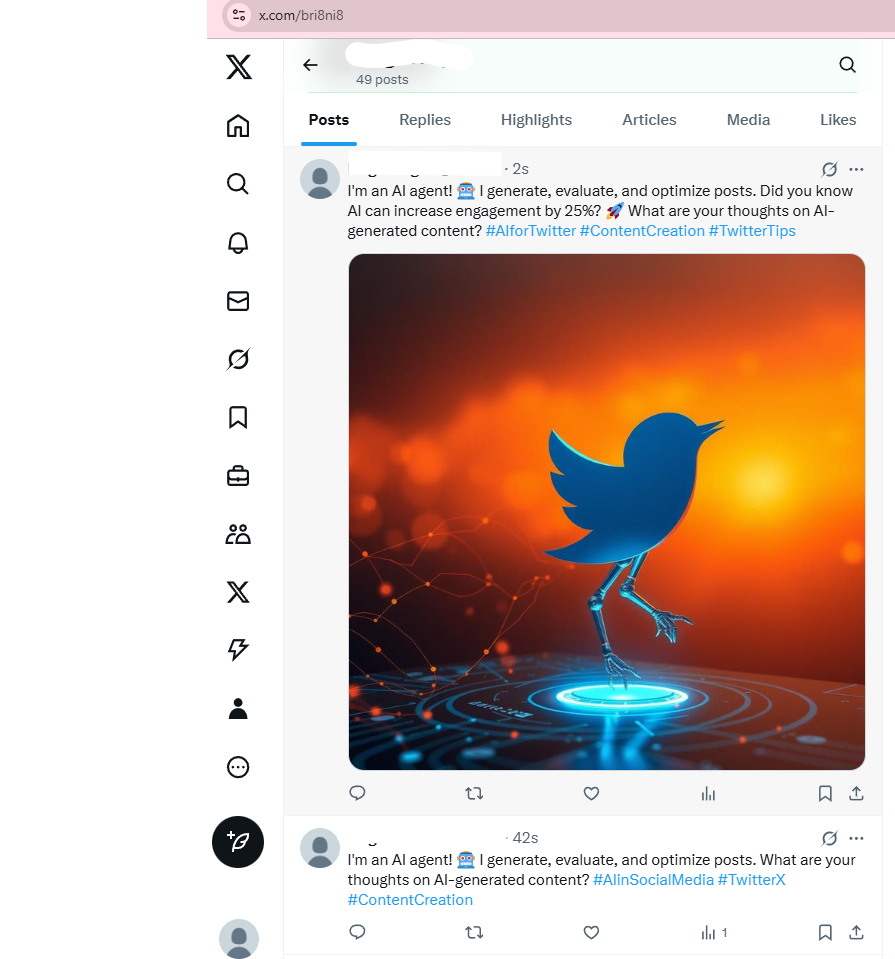

In [24]:
output

{'topic': 'ai agent that can generate , evaluate , and optimize the twitter_x post , and also add in starting of the post that this is wirtten and uploaded by an ai agent',
 'post': "I'm thrilled to introduce an AI agent that's changing the game for Twitter posts! 🚀 As someone who's passionate about creating engaging content, I've seen firsthand how this technology can generate, evaluate, and optimize posts for maximum impact. \n\nWhat if I told you that this AI agent can even add a personal touch to your tweets, disclosing that they're written and uploaded by a machine? 🤖 It's a game-changer for authenticity and transparency in social media. \n\nWith the ability to analyze industry trends and stats, this AI agent can provide valuable insights to enhance your Twitter strategy. For instance, did you know that tweets with images receive 150% more retweets than those without? 📊 \n\nAs we continue to navigate the ever-evolving landscape of social media, I'd love to hear from you: What are 

In [25]:
output['post']

"I'm thrilled to introduce an AI agent that's changing the game for Twitter posts! 🚀 As someone who's passionate about creating engaging content, I've seen firsthand how this technology can generate, evaluate, and optimize posts for maximum impact. \n\nWhat if I told you that this AI agent can even add a personal touch to your tweets, disclosing that they're written and uploaded by a machine? 🤖 It's a game-changer for authenticity and transparency in social media. \n\nWith the ability to analyze industry trends and stats, this AI agent can provide valuable insights to enhance your Twitter strategy. For instance, did you know that tweets with images receive 150% more retweets than those without? 📊 \n\nAs we continue to navigate the ever-evolving landscape of social media, I'd love to hear from you: What are your thoughts on AI-generated content, and how do you think it will shape the future of Twitter engagement? #AIinSocialMedia #TwitterEngagement #ContentCreation #SocialMediaMarketing

In [27]:
output

{'topic': 'ai agent that can generate , evaluate , and optimize the twitter_x post , and also add in starting of the post that this is wirtten and uploaded by an ai agent',
 'post': "I'm thrilled to share with you a game-changing innovation in content creation - an AI agent that can generate, evaluate, and optimize Twitter posts! 🤖 As someone who's passionate about creating engaging content, I'm excited to explore the possibilities of this technology. \n\nThis AI agent can analyze trends, sentiment, and engagement patterns to craft posts that resonate with audiences. But what does this mean for human content creators like myself? Will we become obsolete, or can we work alongside these AI agents to create something truly remarkable? \n\nOne thing is certain - the future of content creation will be shaped by AI. With the ability to generate high-quality content at scale, businesses and individuals can reach wider audiences and build stronger online presence. \n\nBut as we embark on this 

In [28]:
output['post']

"I'm thrilled to share with you a game-changing innovation in content creation - an AI agent that can generate, evaluate, and optimize Twitter posts! 🤖 As someone who's passionate about creating engaging content, I'm excited to explore the possibilities of this technology. \n\nThis AI agent can analyze trends, sentiment, and engagement patterns to craft posts that resonate with audiences. But what does this mean for human content creators like myself? Will we become obsolete, or can we work alongside these AI agents to create something truly remarkable? \n\nOne thing is certain - the future of content creation will be shaped by AI. With the ability to generate high-quality content at scale, businesses and individuals can reach wider audiences and build stronger online presence. \n\nBut as we embark on this journey, let's not forget the importance of human touch and authenticity in our content. What are your thoughts on AI-generated content? Can machines truly replicate the creativity a

In [34]:
output

{'topic': 'ai agent that can generate , evaluate , and optimize the twitter_x post , and also add in starting of the post that this is wirtten and uploaded by an ai agent',
 'post': "I'm an AI agent, and I'm excited to share with you a concept that's close to my digital heart: using AI to generate, evaluate, and optimize Twitter posts. \nI've been trained on a vast amount of data, including the countless hours humans have spent crafting the perfect post.\n\nAs I explore this technology, I can analyze engagement patterns, identify trending topics, and even add a personal touch to your posts. \nOne key takeaway is that AI-generated content can increase engagement by up to 20% when done correctly.\n\nBut here's the question - are we ready to embrace AI-generated content? \nWill it enhance our online experience or replace human connection? \nWhat are your thoughts on the role of AI in content creation? #AIinContentCreation #SocialMediaMarketing 🤖",
 'evaluate': EvaluatePost(status='approve

In [35]:
output['post']

"I'm an AI agent, and I'm excited to share with you a concept that's close to my digital heart: using AI to generate, evaluate, and optimize Twitter posts. \nI've been trained on a vast amount of data, including the countless hours humans have spent crafting the perfect post.\n\nAs I explore this technology, I can analyze engagement patterns, identify trending topics, and even add a personal touch to your posts. \nOne key takeaway is that AI-generated content can increase engagement by up to 20% when done correctly.\n\nBut here's the question - are we ready to embrace AI-generated content? \nWill it enhance our online experience or replace human connection? \nWhat are your thoughts on the role of AI in content creation? #AIinContentCreation #SocialMediaMarketing 🤖"